In [ ]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency, kstest, boxcox

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, Normalizer


#lib
from lib.clean_data_functions import clean_ext_version, clean_ext_publisher, clean_repo_publisher

#
from ast import literal_eval
from collections import Counter

# os
import os

# time
import time

import warnings
warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

In [371]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

### 1. Loading

In [ ]:
df = pd.read_csv(config["data"]["clean"]["file_data_cleaned"])
df.head()

In [ ]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

In [ ]:
df.info()

#### Metadata:
- **_verified_:**                 check, whether extension's security is breached         (boolean)
- **_ext_categories_:**           categories of extension                                 (obj)   (multi values)
- **_ext\_install\_count_:**      total number of installations of extension              (int64)
- **_ext\_rating_:**              rating of extension (avg of stars rating)               (float64)
- **_repository_:**               url of repository                                       (obj)
- **_total\_vulners_:**           number of detected vulnerabilities                      (int64)
- **_critical\_vulners_:**        number of critical(severity) vulnerabilities            (int64)
- **_high\_vulners_:**            number of high(severity) vulnerabilities                (int64)
- **_medium\_vulners_:**          number of medium(severity) vulnerabilities              (int64)
- **_low\_vulners_:**             number of low(severity) vulnerabilities                 (int64)
- **_repo\_owner_:**              owner of repository (via column repository)             (obj)
- **_repo\_name_:**               name of repository (via column repository)              (obj)
- **_repo\_stars_:**              number of stars of repository (via column repository)   (int64)   
- **_repo\_forks_:**              number of forks of repository (via column repository)   (int64)   
- **repo\_languages:**            program languages used (via column repository)          (obj)   (multi values)


### 3. Preprocessing

In [ ]:
df.duplicated().sum()

In [ ]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]
df

In [377]:
# df["ext_categories"] = df["ext_categories"].str.split(';')
# df["repo_languages"] = df["repo_languages"].str.split(';')

# df = df.explode("ext_categories")
# df = df.explode("repo_languages")

In [378]:
multi_val_columns = ["ext_categories","repo_languages" ]
for col in multi_val_columns:
    df[col] = df[col].str.split(";")
    df = df.explode(col)

In [ ]:
df.head()

In [380]:
# categories_list = []
# for items in df["ext_categories"].values:
#     for item in items:
#         if item not in categories_list:
#                     categories_list.append(item)

In [381]:
df["repo_languages"] = df["repo_languages"].fillna("unknown")

In [ ]:
df = df.drop(columns=["repository", "repo_name", "repo_owner"])
df

### 4. EDA

In [383]:
cols_num = df.select_dtypes(include = ["float","int"]).columns.to_list()
cols_cat = df.select_dtypes(include = ["object", "category"]).columns.to_list()

In [ ]:
cols_num

In [ ]:
df[cols_num].nunique().sort_values(ascending=False)

In [ ]:
df[cols_cat].nunique().sort_values(ascending=False)

In [387]:
# potential_cate_from_num = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]
# potential_cate_from_num

**_Insight_:**

## Univariate Analysis

### Categorical Variables

**Quantitative:**

In [ ]:
proportion_verified = df["verified"].value_counts(normalize=True)
proportion_verified

In [ ]:
proportion_languages = df["repo_languages"].value_counts(normalize=True)
proportion_languages

In [ ]:
proportion_categories = df["ext_categories"].value_counts(normalize=True)
proportion_categories

**_Insight_:**

**Visual/Qualitative:**

Barchart

In [391]:
#Alternative before using explode()

# repo_languages = ""
# for lang in df["repo_languages"]:
#     if not pd.isna(lang):
#         repo_languages += lang + ";"
    
# repo_languages_list = repo_languages.split(';')
# repo_languages_set  = set(repo_languages_list)
# repo_languages_counter=Counter(repo_languages_list)
# repo_languages_counter_common = dict(repo_languages_counter.most_common(12))
# repo_languages_counter

# ext_categories = ""
# for cate in df["ext_categories"]:
#     ext_categories += cate + ";"

# ext_categories_list = ext_categories.split(';')
# ext_categories_set  = set(ext_categories_list)
# ext_categories_counter=Counter(ext_categories_list) #Dict
# ext_categories_counter_common = dict(ext_categories_counter.most_common(12))



In [ ]:
#verified -> target
ax=sns.barplot(x=proportion_verified.index, y=proportion_verified.values, palette="Set3", hue=proportion_verified.index, legend="auto" )

**We have an imbalanced dataset on target** -> majority of extensions is not breached

In [393]:
# proportion_languages_common = df["repo_languages"].value_counts(normalize=True).head(12)
# proportion_categories_common = df["ext_categories"].value_counts(normalize=True).head(12)
# ax=sns.barplot(y=proportion_languages_common.index, x=proportion_languages_common.values, palette="Set3", hue=proportion_languages_common.index, legend="auto" )
# ax=sns.barplot(y=proportion_categories_common.index, x=proportion_categories_common.values, palette="Set3", hue=proportion_categories_common.index, legend="auto" )

In [ ]:
fig, axes = plt.subplots(nrows = len(cols_cat), ncols = 1, figsize = (8, 10))
axes = axes.flat

for i,col in enumerate(df[cols_cat]):
    proportion_common = df[col].value_counts(normalize=True).head(15)
    sns.barplot(y=proportion_common.index,
                x=proportion_common.values,
                palette="Set3",
                hue=proportion_common.index,
                legend="auto",
                ax=axes[i] )
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel("")

fig.suptitle("Barplots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


**_Insight_:**

### Numerical variables

**Quantitative:**

- Measurment of central tendency/dispersion

In [ ]:
df.describe()

In [ ]:
for col in cols_num:

    print("==" * 20)
    print(f"Variable: {col}\n")

    print("--" * 20)
    print(f"Measurements of central tendency:")
    print("--" * 20)
    print(f"Mean = {df[col].mean()}")
    print(f"Median = {df[col].median()}")
    print(f"Mode = {df[col].mode()}")
    print(f"\n")
    print("--" * 20)
    print(f"Measurements of central tendency:")
    print("--" * 20)
    print(f"Var = {df[col].var()}")
    print(f"Standard = {df[col].std()}")
    print(f"Min = {df[col].min()}")
    print(f"Max = {df[col].max()}")
    print(f"Range = {df[col].max()-df[col].min()}")

    print("==" * 20)
    print ()
    

**_Insight_:**

- Shape of distribution

In [ ]:
for column in cols_num:
    skewness_col = df[column].skew()
    kurtosis_col = df[column].kurtosis()

    print("==" * 20)
    print(f"Variable: {column}\n")
    print(f"Skew = {skewness_col}")
    print(f"Kurtosis = {kurtosis_col}")
    print("==" * 20)

    print ()

**_Insight_:**

- Statistical test: use K-S  test and not concern Shapiro due to large dataset

In [ ]:
# standardized_saleprice = (df['SalePrice'] - df['SalePrice'].mean()) / df['SalePrice'].std()
# ks_test_statistic, ks_p_value = kstest(standardized_saleprice, 'norm')

# ks_test_statistic, ks_p_value

# print the test result


for col in cols_num:
    standardized = (df[col] - df[col].mean()) / df[col].std()
    ks_test_statistic, ks_p_value = kstest(standardized, 'norm')
    print("==" * 20)
    print(f"Variable: {col}\n")
    print(f"Test statistic = {ks_test_statistic: .2f}")
    print(f"p_value = {ks_p_value: .2f}")
    print("\n")
    if ks_p_value < 0.05:
        print(f"The distribution of '{col}' is significantly different from a normal distribution.")
    else:
        print(f"The distribution of '{col}'is NOT significantly different from a normal distribution.")

**Visual/Qualitative:**

- Histplot: display the frequency distribution of a dataset. The height of each bar represents the number of data points in each bin.

In [ ]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8, 10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sns.histplot(df[col],
                 kde=True,
                 bins=20,
                 color="orange",
                 ax=axes[i])    
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel("")

fig.suptitle("Hisplots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

**_Insight_:**

- Histogram

In [400]:
# df[cols_num].hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);

- Boxplot/Whisker plot: showcase the central 50% of the data (interquartile range), potential outliers, and other statistical properties.

In [401]:
# for column in cols_num:
#     fig, ax = plt.subplots()#plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

#     sns.boxplot(y = df[column], color="lightblue")
#     ax.set_title(f"Boxplot of {column}")

#     plt.show()
    

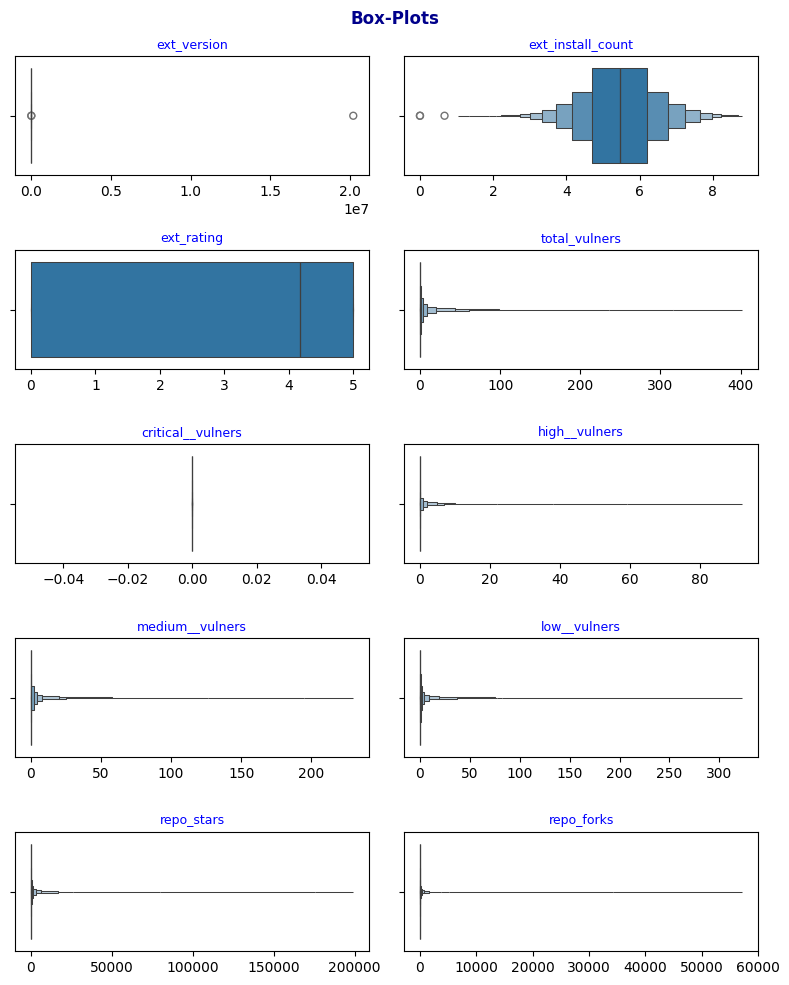

In [417]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    # sns.boxplot(y = df[col],
    #             ax = axes[i])
    sns.boxenplot(x=df[col],
                  ax = axes[i])
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel('')

fig.suptitle("Boxen-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

**_Insight_:**

- QQ-Plot: visualize to help us assess if a dataset follows a particular theoretical distribution/ normal distribution

In [ ]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(df[col], 
           line = "s", 
           ax = axes[i])
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


**_Insight_:** ...

- Binning

In [ ]:
# # Discretizing 'ext_rating' into 3 categories
bins = [0, 1, 4, df["ext_rating"].max()]
labels = ["0", "1 - 3", "4 and above"]
df["ext_rating_category"] = pd.cut(df["ext_rating"], bins=bins, labels=labels, include_lowest=True)
df["ext_rating_category"].value_counts(normalize=True)

In [ ]:
# Discretizing 'ext_version' into 3 categories

bins = [0, 1, df["ext_version"].max()]
labels = ["0", "1 and above"]
df["ext_version_category"] = pd.cut(df["ext_version"], bins=bins, labels=labels, include_lowest=True)
df["ext_version_category"].value_counts(normalize=True)

### Outliers -> will be moved to Preprocessing not EDA

**Outliers detection**

In [404]:
def detect_iqr_outliers(df: pd.DataFrame, column):
    out=[]
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for x in df[column]:
        if x > upper_bound or x < lower_bound:
            out.append(x)
    return out

In [ ]:
for col in cols_num:
    print(f" Total outliers in '{col}':  {len(detect_iqr_outliers(df, col))} \n")

**Outliers removing**

- IRQ-Outliers removing -> Delete observations, not gonna use it

In [ ]:
# def remove_iqr_outliers(df: pd.DataFrame, column) -> pd.DataFrame:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

In [ ]:
cols_num

- Transform 

In [ ]:
# Applying Box-Cox transformation to columns  with high skewness and positive values.
df["ext_install_count"], power_install_count = boxcox(df["ext_install_count"])

print(power_install_count)

# Plotting the transformed distributions
plt.figure(figsize=(10,5))

# Box-Cox transformed 'LotArea'
sns.histplot(df["ext_install_count"], kde=True)
plt.title("Box-Cox Transformed ext_install_count")


# converted_columns = ["ext_rating"]
# for col in 

In [ ]:
df["total_vulners"], power_install_count = boxcox(df["total_vulners"])

print(power_install_count)

# Plotting the transformed distributions
plt.figure(figsize=(10,5))

# Box-Cox transformed 'LotArea'
sns.histplot(df["total_vulners"], kde=True)
plt.title("Box-Cox Transformed total_vulners")